In [3]:
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    Activations,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    AddChannel,
    Transpose,
    AsChannelFirst,
)
from monai.networks.nets import DenseNet
from monai.networks.nets import DenseNet121 # bei dim2 mit Pretrain
from monai.networks.nets import SEResNet50

from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import Dataset, list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint \
    import ModelCheckpoint

# weiteres:
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np

# GRAD CAM Versuch 1
# Monai
from torchcam.cams import SmoothGradCAMpp
from torchvision.transforms.functional import normalize, resize, to_pil_image
# Monai_light
# from torchcam.methods import SmoothGradCAMpp
# from torchvision.transforms.functional import normalize, resize, to_pil_image

# GRAD CAM Versuch 2
# Geht bei Interpreter: "Monai_light" nicht mehr (eventuell haben sich bei neuer version Namen geändert -> Googlen) 
from medcam import medcam
from IPython.display import Image

# Output Metriken
from sklearn.metrics import confusion_matrix, precision_score, classification_report, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, auc, plot_roc_curve, RocCurveDisplay
from sklearn import preprocessing

from torchsummary import summary # Größe des Netzes anzeigen

# Dataloader
from PT_Dataset import TorchDataset # eigenes Python File (PT_Dataset.py) zum Daten laden 
# ACHTUNG: Anpaassen ob schon unsqueez(0) und .float schon vor dem Speichern der Daten gemacht wurde oder nicht 

# ResNet Model
import swav_resnet as resnet_models

# Weights & Biasis
from pytorch_lightning.loggers import WandbLogger # weights and biases logger
from wandb_callbacks import WatchModel, UploadCodeAsArtifact, UploadCheckpointsAsArtifact, LogConfusionMatrix, LogF1PrecRecHeatmap, LogImagePredictions

 # importing cv2 
import cv2 

from logging import getLogger
logger = getLogger()

# Config von monai (welche Version)
print_config()


MONAI version: 0.6.0
Numpy version: 1.20.2
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 8.2.0
Tensorboard version: 2.2.0
gdown version: 3.10.1
TorchVision version: 0.2.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.61.1
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.2.4
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
# FESTLEGEN

# Ordner wo die Ergebnisse gespeichert werden
root_dir = "/home/wolfda/Clinic_Data/Challenge/CT_PreTrain/Downstream/Results/Cut_DiffChen"
print(root_dir)

# Ordner wo die Daten liegen 
data_dir = "/home/wolfda/Clinic_Data/Challenge/CT_PreTrain/Downstream/2D/Cut_DiffChen/Train_2Klasses"
test_dir = "/home/wolfda/Clinic_Data/Challenge/CT_PreTrain/Downstream/2D/Cut_DiffChen/Val/2_Klasses"

# Vortrainierte Gewichte des resNet models
pretrained_weights = "/home/wolfda/Clinic_Data/Challenge/CT_PreTrain/PreTrain_Gesamt/Results/Neu/IM_SwAV_Domain_SwAV__LIDC-MSD-CQ500-AutoPET_lr-5/epoch=1439-train_loss=2.08.ckpt" #"/home/wolfda/Clinic_Data/Challenge/CT_PreTrain/ImageNet/swav_800ep_pretrain.pth.tar" 
# Festlegen
Model = "swav_RibfracCutDiff_downstream"  # NEUES MODEL: zählen A,B;C,..
Versuch = "IM_Supervised_bs16" #"IM_Supervised"  #"Domain_SwAV_lr-5_E559"  #"Scratch" #"IM_SwAV_Domain_SwAV_lr-5_E567"  
wandb_tag= ["nix"] #["Monai_SEResNet"] #["SwAV-Resnet"]#["LIDC-MSD-CQ500_AutoPET"]
# Speicherort Model: save - model*[A,B,C,..] - Versuch*[0,1,2,...]_epoch* - last.ckpt || TB logs: save - model*[A,B,C,..] - logs - default - version*[0,1,2,...]
Epochen = 20 # Wieviele Epochen 
lr = 1e-4 # Learning rate
dp_mlp = 0.0 # Dropout prob[0-1]
bs = 16 # Batch Size Training
# Loss gewichten (Bei welcher klasse sollen fehler stärker bestraft werden)
loss = torch.nn.CrossEntropyLoss() # NLLLoss() falls Netz schon softmax macht | CrossEntropyLoss() falls Netz noch keine Softmax macht  || in (): weight=torch.FloatTensor([0.3,0.7])
optim = "Adam" # Optimizer 

print("Daten:", data_dir, "Model:", Model, "| Versuch:", Versuch, "| Epochen:", Epochen, "| Learning Rate:", lr,  "| Train Bs:", bs,"| loss:", loss, "| Optimizer:", optim)

info={"Path": root_dir, "Daten": data_dir, "weights": pretrained_weights, "Model": Model, "Versuch": Versuch, "Epochen": Epochen, "Learning Rate": lr,  "Train Bs": bs, "loss": loss, "Optimizer": optim}

/home/wolfda/Clinic_Data/Challenge/CT_PreTrain/Downstream/Results/Cut_DiffChen
Daten: /home/wolfda/Clinic_Data/Challenge/CT_PreTrain/Downstream/2D/Cut_DiffChen/Train_2Klasses Model: swav_RibfracCutDiff_downstream | Versuch: IM_Supervised_bs16 | Epochen: 20 | Learning Rate: 0.0001 | Train Bs: 16 | loss: CrossEntropyLoss() | Optimizer: Adam


In [5]:
# Read image filenames from the dataset folders

class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

n_classes = len(class_names)

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label names: {n_classes}")
print(f"Label counts: {num_each}")

Total image count: 1181
Image dimensions: 80 x 80
Label names: ['lable_1', 'lable_2']
Label names: 2
Label counts: [618, 563]


In [6]:
# Read image filenames from the Test folders

class_names_val = sorted(x for x in os.listdir(test_dir)
                     if os.path.isdir(os.path.join(test_dir, x)))
num_class_val = len(class_names_val)
image_files_val = [
    [
        os.path.join(test_dir, class_names_val[i], x)
        for x in os.listdir(os.path.join(test_dir, class_names_val[i]))
    ]
    for i in range(num_class_val)
]
num_each_val = [len(image_files_val[i]) for i in range(num_class_val)]
image_files_list_val = []
image_class_val = []
for i in range(num_class_val):
    image_files_list_val.extend(image_files_val[i])
    image_class_val.extend([i] * num_each_val[i])
num_total_val = len(image_class_val)
image_width_val, image_height_val = PIL.Image.open(image_files_list_val[0]).size

n_classes_val = len(class_names_val)

print(f"Total image count: {num_total_val}")
print(f"Image dimensions: {image_width_val} x {image_height_val}")
print(f"Label names: {class_names_val}")
print(f"Label names: {n_classes_val}")
print(f"Label counts: {num_each_val}")

Total image count: 132
Image dimensions: 80 x 80
Label names: ['lable_1', 'lable_2']
Label names: 2
Label counts: [69, 63]


(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)


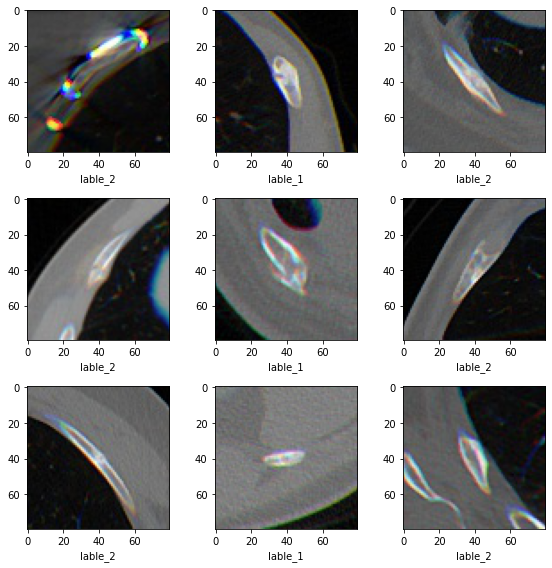

In [7]:
# Visualization check (Braucht man nicht unbedingt)
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    #arr = cv2.cvtColor(arr,cv2.COLOR_GRAY2RGB) # macht 3 Channel (3 mal das gleiche) 
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
    print(arr.shape)
plt.tight_layout()
plt.show()

In [8]:
# Train, Val, Test 

reduce_train = 1 # % of Dataset [1 wenn alle Daten] (Nur Train wird verkleinert; Val, Test bleiben konstant)

val_frac = 0.11 # % Validation
length = len(image_files_list)
indices = np.arange(length)
np.random.seed(0) # Bei jedem Run genau die gleichen gleichen Bilder in train, val, test
np.random.shuffle(indices)

val_split = int(val_frac * length) # Länge Test
train = (length - val_split) * reduce_train # Länge Train: (GesamtLänge - Länge Länge Val,Test)* Reduce_Data
val_indices = indices[:val_split]
train_indices = indices[val_split:(int(train)+val_split)]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]

test_x = image_files_list_val
test_y = image_class_val

print("Reduce Train:", reduce_train*100, "%" )
print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Reduce Train: 100 %
Training count: 1052, Validation count: 129, Test count: 132


In [9]:
# Transforms

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        #AddChannel(),
        AsChannelFirst(channel_dim=- 1),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        #RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), AsChannelFirst(channel_dim=- 1), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)])

In [10]:
# PT Dataset

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [11]:

# Modell Laden -----------------------------------------------------------------------------

# Mögl1:
# -> Vortrainiertes MLP von SwAV + Eigenes MLP um auf Anzahl Klassen zu kommen
#res_model = resnet_models.__dict__["resnet50"](hidden_mlp=2048, output_dim=128) # wurde oben importiert  
# -> hidden_mlp=self.hidden_mlp=2048, output_dim=128 Gleiche Einstellungen wie beim PreTrain
# -> Output Netz: 128

# # Mögl2:
# -> Ohne Vortrainiertes MLP von SwAV, hängt einfach ein einzelnes Linear Layer dran um auf Anzahl Klassen zu kommen 
#res_model = resnet_models.__dict__["resnet50"](output_dim=n_classes)
# -> unten: x = self.mlp(x) weg!!!!!!!!!!!!!

# SEResNet50 Monai (ImageNet PreTrain)
res_model = SEResNet50(spatial_dims=2, in_channels=3, layers=(3, 4, 6, 3), groups=1, reduction=16, dropout_prob=0.0, inplanes=64, downsample_kernel_size=1, input_3x3=False, pretrained=True, progress=True, num_classes=n_classes)

# Geht nicht: 
# convert batch norm layers
#res_model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(res_model)


# Vortrainierte Gewichte Laden --------------------------------------------------------------------------------
# state_dict = torch.load(pretrained_weights)  #pretrained_weights
# if "state_dict" in state_dict:
#     state_dict = state_dict["state_dict"]
    
# # remove prefixe "module." or "model."
# #Checkpoints als 'model.conv1.weight' gespeichert und Netzs als 'conv1.weight' -> model. entfernen
# state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()} # Meine Checkpoints (model)
# #state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()} # ImageNet PreTrian von swav (module) 
# #print(state_dict.items())

# for k, v in res_model.state_dict().items():
#     if k not in list(state_dict):
#         print('key "{}" could not be found in provided state dict'.format(k))
#     elif state_dict[k].shape != v.shape:
#         print('key "{}" is of different shape in model and provided state dict'.format(k))
#         state_dict[k] = v
# msg = res_model.load_state_dict(state_dict, strict=False)
# print("Load pretrained model with msg: {}".format(msg))



In [12]:
class Net(pytorch_lightning.LightningModule): # Name: Net **1
    
    # Netz + Loss definieren
    def __init__(self):
        super().__init__()
        
        # PreTrained Model
        self.model = res_model
        # Output: bs,128
        
        # MLP Classifier
        self.mlp = torch.nn.Sequential(
                #Flatten(),
                torch.nn.Dropout(p=dp_mlp),
                torch.nn.Linear(128, 64, bias=False), # Output von PreTrained Netz ist 128!!!!!!!!!!!!!!!!!!!!!!!!
                torch.nn.BatchNorm1d(64),
                torch.nn.ReLU(inplace=True),
                torch.nn.Dropout(p=dp_mlp),
                torch.nn.Linear(64, n_classes, bias=True),
            )
        
        # Loss
        self.loss_function = loss 
        
    # Freeze Funktion:

    def forward(self, x):
        
        x = self.model(x)
        
        # Nur bei Mögl1: (mit Vortrainiertem MLP + eigenem MLP)
        #x = self.mlp(x) 


        return x

    def prepare_data(self):
        
        set_determinism(seed=0)
        # Erstellt Dataset (Pfad in dem alle Bilder + lable liegen ([vol, class]) übergeben)
        self.train_ds = MedNISTDataset(train_x, train_y, train_transforms)
        self.val_ds = MedNISTDataset(val_x, val_y, val_transforms)
        self.test_ds = MedNISTDataset(test_x, test_y, val_transforms)
        
    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.train_ds, batch_size=bs, shuffle=True, num_workers=10)
        print("Train Data Loader | Bs:", bs, "| len",  len(train_loader), "| ges", bs*len(train_loader))
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(self.val_ds, batch_size=1, num_workers=10)
        print("Val Data Loader", len(val_loader))
        return val_loader
    
    def test_dataloader(self): 
        test_loader = torch.utils.data.DataLoader(self.test_ds, batch_size=1, num_workers=10)
        print("Test Data Loader", len(test_loader))
        return test_loader

    def configure_optimizers(self):
        if optim == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr)
        return optimizer

    def training_step(self, batch, batch_idx): # batch: PT Dataset
        images, labels= batch 
        #print("Training", images.shape, labels.shape)
        
        output = self.forward(images) 
        #print("Train Outputs", output)
        #print("Train Labels", labels)
        
        loss = self.loss_function(output, labels) # cross entropy Loss
        tensorboard_logs = {"train_loss": loss.item()}

        return {"loss": loss, "log": tensorboard_logs}
    
    def training_epoch_end(self, outputs): # outputs = Elemente im train Dataset  x {"loss": loss, "log": tensorboard_logs}
        #print("All Train Losses", outputs)
        train_loss, num_items = 0, 0
        
        for output in outputs: # Durchläuft alle elemete im train Dataset 
            #print("Nummer:", num_items)
            
            #print("Train Loss", output["loss"].sum().item())
            train_loss += output["loss"].sum().item() # Alle Losse aufaddieren 
            num_items += 1
            
        mean_train_loss = torch.tensor(train_loss / num_items) # mittlerer Loss
        #print("Train Loss Mean", mean_train_loss)
        
        tensorboard_logs = {
            "training_loss": mean_train_loss,
        }
        
        return {"log": tensorboard_logs}
    

    def validation_step(self, batch, batch_idx): # batch: von Data Loader
        images, labels= batch # [1, 1, 48, 256, 256], [1] 
        #print("Val", images.shape, labels.shape)
        
        #images = torch.rand(1,20,512,512).cuda()
        
        outputs = self.forward(images) # [4]
        #print("Val Outputs", outputs)
        #print("Val Labels", labels)
        
        klasse = torch.argmax(outputs, dim=1)
        
        loss = self.loss_function(outputs, labels)
        
        #klasse = int(klasse.item())
        #labels = int(labels.item())
        
        return {"val_loss": loss, "targets": labels, "preds": klasse}
    

    def validation_epoch_end(self, outputs): # outputs = Elemente im Val Dataset x {"val_loss": loss}
        #print("All Val Losses", outputs)
        val_loss, num_items, true, false = 0, 0, 0, 0 
        
        
        for output in outputs: # Durchläuft alle elemete im Val Dataset 
            #print("Nummer:", num_items)
            
            #print("Val Loss", output["val_loss"].sum().item())
            val_loss += output["val_loss"].sum().item() # Alles Losse aufaddieren 
            num_items += 1
            
            if output["preds"] == output["targets"]: # wenn Index mit höchster Wahrschl. == richtige Klasse -> richtig klassifiziert
                true += 1
            else:
                false += 1
            
        mean_val_loss = torch.tensor(val_loss / num_items) # mittlerer Loss
        #print("Val Loss Mean", mean_val_loss)
        
        # Accurancy
        acc = torch.tensor(true / num_items)
        
        tensorboard_logs = {
            "val_loss": mean_val_loss,
            "val_accuracy": acc
        }
        
        return {"log": tensorboard_logs}
    
    def test_step(self, batch, batch_idx): # batch: von Data Loader
        images, labels = batch # [1, 1, 48, 256, 256], [1] 
        #print("Test", images.shape, labels.shape)
        
        outputs = self.forward(images) # [4]
        outputs = torch.nn.functional.softmax(outputs)
        #print("Test Outputs", outputs.shape)
        #print("Test Labels", labels.shape)
        
        klasse = torch.argmax(outputs, dim=1)
        #print("Test Predict", klasse)
        
        loss = self.loss_function(outputs, labels)
        #print("Test Loss", loss.item())
        
        return {"test_loss": loss, "output": outputs, "lable": labels, "klasse": klasse} 
    
    def test_epoch_end(self, outputs): # outputs = Elemente im Val Dataset  x {"test_loss": loss, "output": outputs, "lable": labels, "klasse": klasse, "Name": name}
        #print("All Test Losses", outputs)
        
        test_loss, true, false, num_items = 0, 0, 0, 0
        
        output_list = np.array([])
        lable_list = np.array([])
        output_prob_1 = np.array([])
        output_prob_0 = np.array([])
        output_prob = np.array([])
        
        i = 0
        for output in outputs: # Durchläuft alle elemete im Test Dataset 
            #print("Nummer:", num_items)
            
            #print("Test Loss", output["test_loss"])
            test_loss += output["test_loss"] # alles Losse aufadieren
            num_items += 1
            
            output_hold = output["klasse"].cpu().detach()
            #print(output_hold)
            lable_hold = output["lable"].cpu().detach()
            #print(lable_hold)
            output_prob_hold = output["output"].cpu().detach()
            
            output_list = np.append(output_list, output_hold) # Predicted Class 0...5
            lable_list = np.append(lable_list, lable_hold) # Lable Class 0...5

            
            #print(output["Name"])
            #print("Test Output", output["klasse"]) # One hot (hier nicht nötig: torch.nn.functional.one_hot(output["klasse"], 2))
            #print("Test Lable", output["lable"])
            
            if output["klasse"] == output["lable"]: # wenn Index mit höchster Wahrschl. == richtige Klasse -> richtig klassifiziert
                true += 1
            else:
                false += 1
            i+=1
        
        # __________ DOKU ____________________________
        
        # Output Networtk, Lables

        
        # Anzahl richtig klassifiezert
        print("\n" + "True", true) 
        print("False", false)
        
        # Accurancy
        acc = torch.tensor(true / num_items) 
        print("\n" + "acc", acc)
        
        # Mean Loss
        mean_test_loss = torch.tensor(test_loss / num_items) # mittlerer Loss
        #print("\n" + "mean_loss", mean_test_loss)
        
        # Confusion Matrix (output_list, lable_list: torch tensors mit den ausgaben des Netztes und den Lablen für alle Patienten in Testset)
        #print("\n" + "Confution Matrix")
        cm = confusion_matrix(lable_list, output_list)
        #print(cm)
        
        # Precision
        #print("\n" + "Precision Score Classes: ")
        # print(list(preprocessing.LabelEncoder.classes_))
        score01 = precision_score(lable_list, output_list, average=None)
        print("precision_score", score01)
        
        # Report: Precision, Recall, F-Score
        print("\n" +"Classification Report: ")
        score01 = classification_report(lable_list, output_list)
        print(score01)
        
        # Display Confusion Matric nicer
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
        disp.plot(cmap="Blues")
        
        # Sensitivity = true positive rate = TruePositive / (TruePositive + FalseNegative); Specificity = TrueNegative / (FalsePositive + TrueNegative)
        # G-Mean = sqrt(Sensitivity * Specificity), Geometric Mean will seek a balance between the sensitivity and the specificity
        # fpr(=false positive rate), tpr(=true positive rate =Sensitivity) , thresholds (differtent thresholds [normal: <0.5=0; >0.5=1] jetzt 0.1 0.2 0.3 ... bei denen die fpr und tps gemessen wird)
        
        # fpr(=false positive rate), tpr(=true positive rate =Sensitivity) , thresholds (differtent thresholds [normal: <0.5=0; >0.5=1] jetzt 0.1 0.2 0.3 ... bei denen die fpr und tps gemessen wird)
#         fpr, tpr, thresholds = roc_curve(lable_list, output_prob_1, sample_weight=None) # Wahrscheinlichkeiten der Klasse die seltener vorkommt
#         print("fpr", fpr)
#         print("tpr", tpr)
#         roc_auc = auc(fpr, tpr)
#         print("AUC")
#         print(roc_auc)
        
#         # Perfekt threshold to take, instead of threshold 0.5
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print("Threshold", thresholds[ix], "tpr Value", gmeans[ix])
        
#         display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='')
#         #display.plot()
        
#         f, ax = plt.subplots(figsize=(15, 9))
#         plt.plot([0,1],[0,1], 'k--')
#         plt.plot(fpr, tpr, label= "DaniNet")
#         plt.legend()
#         plt.xlabel("FPR")
#         plt.ylabel("TPR")
#         plt.title('Receiver Operating Characteristic')
#         plt.show()
        
        tensorboard_logs = {
            "test_loss": mean_test_loss,
            "test_acc": acc
        }
        
        return {"log": tensorboard_logs}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: wolfda95 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name          | Type             | Params
---------------------------------------------------
0 | model         | SEResNet50       | 26 M  
1 | mlp           | Sequential       | 8 K   
2 | loss_function | CrossEntropyLoss | 0     


Val Data Loader 129


Validation sanity check: 0it [00:00, ?it/s]

Train Data Loader | Bs: 16 | len 66 | ges 1056
Val Data Loader 129


/home/wolfda/anaconda3/envs/Monai/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/wolfda/anaconda3/envs/Monai/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


Test Data Loader 132


Testing: 0it [00:00, ?it/s]

/tmp/ipykernel_29142/829093533.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs)



True 82
False 50

acc tensor(0.6212)
precision_score [0.63013699 0.61016949]

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65        69
         1.0       0.61      0.57      0.59        63

    accuracy                           0.62       132
   macro avg       0.62      0.62      0.62       132
weighted avg       0.62      0.62      0.62       132

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.6212), 'test_loss': tensor(0.6517, device='cuda:0')}
--------------------------------------------------------------------------------


/tmp/ipykernel_29142/829093533.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_test_loss = torch.tensor(test_loss / num_items) # mittlerer Loss


[{'test_loss': 0.6517163515090942, 'test_acc': 0.6212121248245239}]

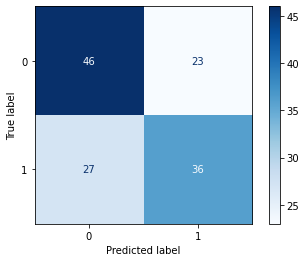

wandb: Network error (ReadTimeout), entering retry loop.


In [14]:
# Train, Test, Save

# initialise the LightningModule
net = Net()

# Pfad zum Speichern: 
log_dir = os.path.join(root_dir, "save", "model_" + Model, "logs") # tensorboard logs
checkpoint_dir = os.path.join(root_dir, "save", "model_" + Model, "versuch_" + Versuch) # model 

# weights and biases
wandb_logger = WandbLogger(project=Model, name=Versuch, tags = wandb_tag, save_dir=checkpoint_dir)

# tensorboard loggers speichern
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(save_dir=log_dir) # macht jedes mal ein neuen Ordner auf (logs-default-version*[0,1,2...])

# Netz speichern 
checkpoint_callback = ModelCheckpoint( #  macht jedes mal ein neuen Ordner auf (logs-"test1-{epoch}-{val_loss:.2f}") speichert Stand des letzten Trainingsschritts
    filepath=os.path.join(checkpoint_dir, "{epoch}-{val_loss:.2f}"), # Speicher Pfad **2
    save_last = True, # Speichert den Stand der letzten Epoche des Trainings (Name: last.ckpt)
    save_top_k=100, # Speichert den Stand der k=2 besten Epochen [bester val loss] des Trainings (Name: epoch=*-val_loss=*.ckpt)
)
#############################################################################################################################################################
# ToDo
# logger_callback = [
#     ModelCheckpoint
#     ( 
#     dirpath=os.path.join(checkpoint_dir, "{epoch}-{val_loss:.2f}"), # Speicher Pfad **2
#     save_last = True, # Speichert den Stand der letzten Epoche des Trainings (Name: last.ckpt)
#     save_top_k = -1 
#     ), 
#     WatchModel(), 
#     UploadCheckpointsAsArtifact(), 
#     LogConfusionMatrix(), 
#     LogF1PrecRecHeatmap(), 
#     LogImagePredictions()]
# File callbacks, ... kopieren 

# Info Speichern
torch.save(info, checkpoint_dir + "/info.pt")


# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[1],
    max_epochs=Epochen, # Epochen
    #logger=tb_logger, # tensorboard 
    logger=wandb_logger, # weight & biasis 
    checkpoint_callback = checkpoint_callback, # Model checkpoints speichern
    #callbacks = logger_callback, 
    num_sanity_val_steps=1,
    #resume_from_checkpoint = pretrained_weights
)

# train + val
trainer.fit(net)

# test
trainer.test(net)

In [ ]:
### Test mit trainiertem Modell (A) Testdurchlauf mit den kompletten Testdaten
# Legt eine Datei "lightning_logs" an, die einfach löschen 

# Trainiertes Model wieder Laden (mit Pfad wie oben festgelegt **2)
net = Net.load_from_checkpoint( # "Net" ist der Name unseres Netzes **1
    "/home/wolfda/Clinic_Data/Challenge/CT_PreTrain/Downstream/Results/SameChen_Ges/save/model_swav_RibfracSameGes_downstream/versuch_Domain_SwAV_lr-5_E567_seed0/epoch=19-val_loss=0.41.ckpt" # [model: A,B,C,..], [versuch: 0,1,2,..]
) # letzte Epoche: last.ckpt | Besten 2 Epochen: epoch=5-val_loss=1.34.ckpt
# ACHTUNG: Oben die Richtigen Daten nehmen + Richtiges Netz

# Info über das Netz
print(summary(net))

# Info
#print("INFO:", torch.load("/home/wolfda/Clinic_Data/Data/Covid_Concern/Networks/3D_DenseNet_PreTrain/save/model_E/versuch_0/info.pt")) # [model: A,B,C,..], [versuch: 0,1,2,..]

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[-1],
    max_epochs=4,
    num_sanity_val_steps=1,
    checkpoint_callback=False
)

# test
out = trainer.test(net)
#print(out)

# Eval Modus (macht PT Lightning bei model.test automatisch)
Netz = net.eval()
# Das ganze Netzt ausgeben
#print("Ganzes Netz: ")
#print(Netz)

/tmp/ipykernel_3080687/1001644334.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = torch.nn.functional.softmax(y_hat)


tensor([0], device='cuda:0')


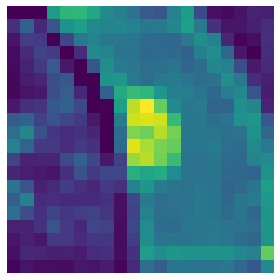

In [13]:
###### Explainable AI
import monai

# Trainiertes Model wieder Laden (mit Pfad wie oben festgelegt **2)
model = Net.load_from_checkpoint("/home/wolfda/Clinic_Data/Challenge/CT_PreTrain/Downstream/Results/Cut_DiffChen/save/model_swav_RibfracCutDiff_downstream/versuch_IM_Supervised_bs4/epoch=19-val_loss=0.99.ckpt") # "Net" ist der Name unseres Netzes **1
# letzte Epoche: last.ckpt | Besten 2 Epochen: epoch=5-val_loss=1.34.ckpt


# Image Laden

# Image Path (png / jpeg)
image_path = "/home/wolfda/Clinic_Data/Challenge/CT_PreTrain/Downstream/2D/Cut_DiffChen/Val/2_Klasses/lable_2/RibFrac443_2_lable_2.jpeg"

# Monai png/jpeg laden
load = monai.transforms.LoadImage()
im = load(image_path)
image = im[0]
#print(image.shape)

# Channel vorne (512x512x3 -> 3x512x512)
channel = monai.transforms.AsChannelFirst(channel_dim=- 1)
image = channel(image)

# Eine Dim dranhängen (1x3x512x512)
image = np.expand_dims(image, 0)
#print(image.shape)

# Numpy to torch
image = torch.from_numpy(image)

# Auf Grafikkarte 
image = image.cuda()

# Grad Cam
cam_extractor = SmoothGradCAMpp(model, input_shape = [3, 512, 512])

# Namen der Layer:
#print(medcam.get_layers(model))

# M3d-CAM: gbp (Guided Backpropagation) | gcam (Grad-Cam, default) | ggcam (Guided Grad-Cam) | gcampp (Grad-Cam++)
# Geht bei Interpreter "Monai_light" nicht mehr (schon bei Import oben) -> eventuell haben sich bei neuer Version die Namen gändert -> Googlen 
model = medcam.inject(model, output_dir="attention_maps", backend='gcam', label='best', save_maps=True)
# Speichert es da wo code liegt in Ordner "attention_maps"

model.eval()
y_hat = model(image) # Das Bild von einem Patienetn ins Netz geben

output = torch.nn.functional.softmax(y_hat)
klasse = torch.argmax(output, dim=1)
print(klasse)


# Grad Cam
activation_map = cam_extractor(torch.argmax(y_hat, dim=1).item(), y_hat)
# Visualize the raw CAM
plt.imshow(activation_map.cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()